# The dataset we use can be found on the Kaggle website
### https://www.kaggle.com/c/store-sales-time-series-forecasting/data

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [117]:
train_data = pd.read_csv("train.csv")
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [118]:
test_data = pd.read_csv("test.csv")
test_data.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Splitting the Date Column
 The `date` column is composed of three components: year, month, and day. To facilitate time-based analysis, we split this column into separate `year`, `month`, and `day` columns, and convert each of them to integers.

In [119]:

train_data[['year', 'month', 'day']] = train_data['date'].str.split('-', expand=True).astype(int)
train_data.head(5)

,id,date,store_nbr,family,sales,onpromotion,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1


### Extracting Time-Based Features

To capture temporal patterns in the sales data, we extract additional features from the `date` column:

- `dayofweek`: Integer from 0 (Monday) to 6 (Sunday), indicating the day of the week.
- `weekofyear`: ISO calendar week number of the year, useful for identifying seasonal trends.
- `is_weekend`: Binary indicator (1 if Saturday or Sunday, 0 otherwise), which may influence shopping behavior.

These features help the model understand weekly cycles and seasonal sales behavior.


In [120]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['dayofweek'] = train_data['date'].dt.dayofweek     # 0 = Monday, 6 = Sunday
train_data['weekofyear'] = train_data['date'].dt.isocalendar().week
train_data['is_weekend'] = train_data['dayofweek'].isin([5, 6]).astype(int)

In [121]:
sales = train_data['sales']

# Exploratory Data Analysis

In [122]:
print(train_data.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
dayofweek      0
weekofyear     0
is_weekend     0
dtype: int64


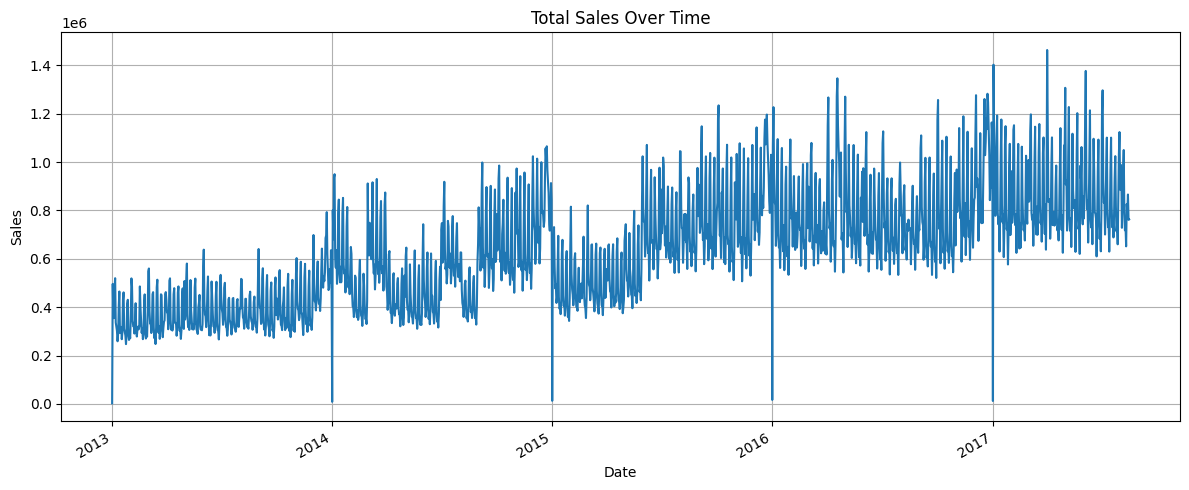

In [123]:
plt.figure(figsize=(12, 5))
train_data.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Sales Over Time

- A clear upward trend in sales over the years, indicating business growth.
- Recurring seasonal patterns, likely linked to holidays and promotional events.
- Several sharp drops in sales, which may correspond to holidays when stores were closed or data gaps.

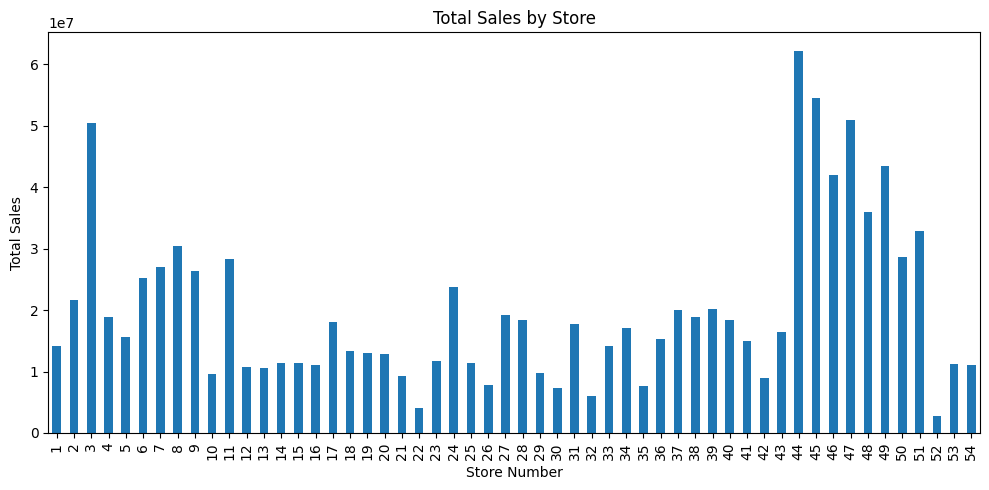

In [124]:
store_sales = train_data.groupby('store_nbr')['sales'].sum().sort_index()

plt.figure(figsize=(10, 5))
store_sales.plot(kind='bar')
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

## Total Sales by Store

#### This bar chart displays the total sales for each store over the entire time period.

- Store 44, 45, and 47 show the highest overall sales, indicating they are likely high-traffic or high-performing locations.
- There is considerable variation in total sales between stores, suggesting differences in location size, customer base, or product availability.
- Some stores, such as Store 22 and Store 52, have noticeably lower sales volumes.

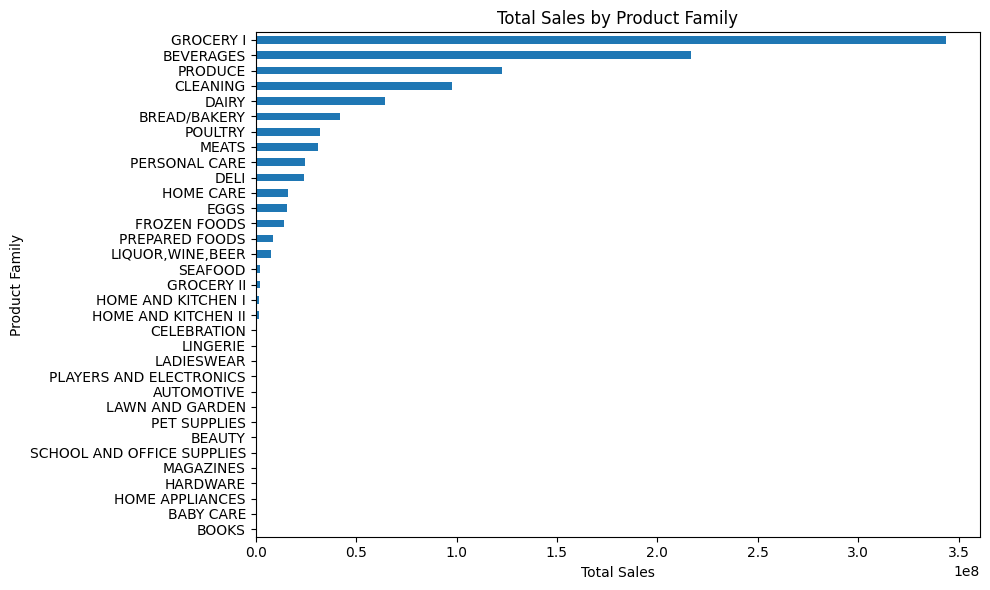

In [125]:
family_sales = train_data.groupby('family')['sales'].sum().sort_values()

plt.figure(figsize=(10, 6))
family_sales.plot(kind='barh')
plt.title('Total Sales by Product Family')
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

## Total Sales by Product Family

#### This horizontal bar chart shows the total sales for each product family across all stores and dates.

Key insights:
- GROCERY I and BEVERAGES are the top-selling categories by a large margin, suggesting they are core drivers of revenue.
- Categories like BOOKS, BABY CARE, and HOME APPLIANCES generate significantly lower sales.

### First model

In [126]:
train_data = train_data.sort_values('date')
train_data['target'] = train_data.groupby(['store_nbr', 'family'])['sales'].shift(-1)
train_data = train_data.dropna(subset=['target'])
train_data['target'] = train_data['target'].astype(int)

In [127]:
train_data.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
year                    int64
month                   int64
day                     int64
dayofweek               int32
weekofyear             UInt32
is_weekend              int64
target                  int64
dtype: object

In [128]:
X = train_data.drop(['sales', 'id', 'date', 'target', 'family'], axis=1)
y = train_data['target']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [130]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [131]:
y_fit  = model.predict(X_train)
y_pred = model.predict(X_test)

In [132]:
mae = mean_absolute_error(y_train, y_fit)

print(f"Training MAE: {mae:.2f}")

Training MAE: 444.23


In [133]:
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {test_mae:.2f}")

Test MAE: 562.78


In [136]:
y_train.describe().round(0)

count    2399284.0
mean         328.0
std         1025.0
min            0.0
25%            0.0
50%            8.0
75%          178.0
max       124717.0
Name: target, dtype: float64

In [137]:
y_test.describe().round(0)

count    599822.0
mean        476.0
std        1361.0
min           0.0
25%           3.0
50%          26.0
75%         269.0
max       89576.0
Name: target, dtype: float64

### 📉 Why the Linear Regression Model Underperformed

The linear regression model yielded a high mean absolute error (MAE), particularly on the test set, indicating poor generalization. Several factors contribute to this:

---

#### 1. **Extreme Skew in Target Variable**
- The target (`target`) is highly skewed.
- The mean value is only 328, but the maximum is over 124,000.
- Linear regression minimizes squared error, so it disproportionately focuses on large outliers, which distorts predictions for the majority of low-sale items.

---

#### 2. **Non-Linear Relationships**
- Sales are influenced by complex, nonlinear factors such as:
  - Promotions
  - Calendar effects (weekends, holidays)
  - Lagged sales trends
- Linear regression can only model linear relationships and fails to capture these complex patterns unless heavily feature-engineered.

---

#### 3. **No Log Transformation Applied**
- Linear models assume the target variable is normally distributed with constant variance (homoscedasticity).
- In this case, sales are heavily right-skewed. Without applying a log transformation, the model struggles to learn effectively.

---

#### 4. **Lack of Time-Aware Features**
- The model lacks important features like:
  - Lagged sales (e.g. yesterday’s or last week’s sales)
  - Rolling averages
- These are essential for forecasting in time series data, especially retail sales.


## ⏳ Cross-Validation Training Loop

To evaluate multiple models robustly and fairly, we implemented a **TimeSeriesSplit-based training loop**.
